<a href="https://www.kaggle.com/code/omershlomo/cheetah-hyena-jaguar-and-tiger-classification?scriptVersionId=116869555" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Importing our Data**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os, shutil
import torch
import albumentations as albu
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision
import time

batch_size = 32
learning_rate = 0.05


%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
DATA_DIR = '/kaggle/input/cheetahhyenajaguarandtigerv2/data'

TRAIN_DIR = DATA_DIR + '/train'                           
TEST_DIR = DATA_DIR + '/valid' 

# **Check out our classes from the Data**

In [3]:
classes = os.listdir(TRAIN_DIR)
classes

['Cheetah', 'Tiger', 'Jaguar', 'Hyena']

In [4]:
classes = os.listdir(DATA_DIR + "/train")
print(len(classes),'classes :', classes)

4 classes : ['Cheetah', 'Tiger', 'Jaguar', 'Hyena']


# **Create Dataset from the data**

In [5]:
dataset = ImageFolder(DATA_DIR + '/train', transform=transforms.ToTensor())
print('Size of training dataset :', len(dataset))

Size of training dataset : 3600


In [6]:
test = ImageFolder(DATA_DIR + '/valid', transform=transforms.ToTensor())
print('Size of test dataset :', len(test))

Size of test dataset : 400


# **Create Example of one picture from the dataset** 

Label:  Cheetah (0)


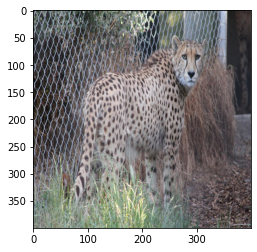

In [7]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[0])

In [8]:
torch.manual_seed(43)
val_size = 400
train_size = len(dataset) - val_size

In [9]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3200, 400)

# **Loading the Dataset and create Trainloader and Testloader over it**

In [10]:

def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader



trainloader, testloader = load_split_train_test(DATA_DIR, .2)
print(trainloader.dataset.classes)

['train', 'valid']


# **Create Grid over the pictures from our training Set**

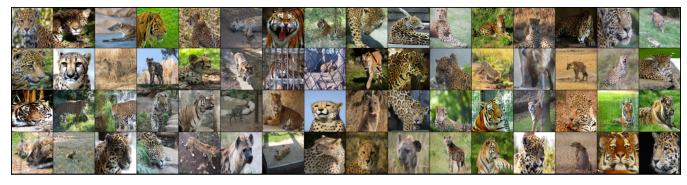

In [11]:
for images, labels in trainloader:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

# Checking wich device we work with -'Gpu' or 'Cpu'

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Using Traind model of Resnet50 to train our data over this trained model**

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **Optimzing the traind model**

In [14]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **Strating to train our Data over the trained Model of Resnet50**

In [15]:
epochs = 5
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
last_acc=0
best_acc=0
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1       
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f" \n"
                  f"Epoch {epoch+1}/{epochs} "
                  f" \n"
                  f"Train loss: {running_loss/print_every:.3f} "
                  f"Test loss: {test_loss/len(testloader):.3f} \n"
                  f"------------------------------------------------")
            print(f" \n"
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            current_acc= accuracy/len(testloader)
            
            if current_acc >last_acc:
              best_acc = accuracy/len(testloader)
            
            last_acc=current_acc
            running_loss = 0
            model.train()
torch.save(model, 'Omermodel.pth')
print(f"The best accuracy is:{(best_acc*100):.3f}%")

 
Epoch 1/5  
Train loss: 1.697 Test loss: 1.873 
------------------------------------------------
 
Test accuracy: 0.906
 
Epoch 1/5  
Train loss: 1.054 Test loss: 0.710 
------------------------------------------------
 
Test accuracy: 0.903
 
Epoch 1/5  
Train loss: 0.789 Test loss: 0.325 
------------------------------------------------
 
Test accuracy: 0.904
 
Epoch 1/5  
Train loss: 0.459 Test loss: 0.325 
------------------------------------------------
 
Test accuracy: 0.900
 
Epoch 1/5  
Train loss: 0.378 Test loss: 0.340 
------------------------------------------------
 
Test accuracy: 0.903
 
Epoch 2/5  
Train loss: 0.344 Test loss: 0.316 
------------------------------------------------
 
Test accuracy: 0.903
 
Epoch 2/5  
Train loss: 0.319 Test loss: 0.317 
------------------------------------------------
 
Test accuracy: 0.905
 
Epoch 2/5  
Train loss: 0.382 Test loss: 0.333 
------------------------------------------------
 
Test accuracy: 0.905
 
Epoch 2/5  
Train loss

# **Create a graph to show the traning of the loss from the Training set over the loss of our Test set**

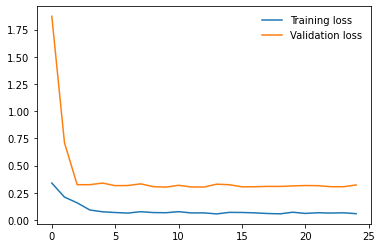

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [17]:
data_dir = '/kaggle/input/cheetahhyenajaguarandtigerv2/data/train'


test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('Omermodel.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **Preparing images to show how our model trained and which pictures its predicting over the first class "Cheetah"**

In [19]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [20]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

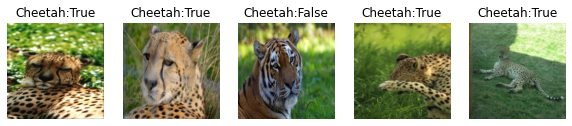

In [21]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()